# **Project - Recommendation Systems: Movie Recommendation System**


---------------
## **Context**
---------------

Online streaming platforms like **Netflix** have plenty of movies in their repository and if a **Recommendation System** model is built to recommend **relevant movies** to users, based on their **historical interactions**, this would **improve customer satisfaction** and hence, it will also improve the revenue of the platform. The techniques that I have applied here will not only be limited to movies, they can be applied to any item for which a recommendation system is to be built.

-----------------
## **Objective**
-----------------

In this project I will be building various recommendation systems: 
- Knowledge/Rank based recommendation system
- Similarity-Based Collaborative filtering
- Matrix Factorization Based Collaborative Filtering

The **ratings** dataset will be used in this project.

-----------------
## **Dataset**
-----------------

The **ratings** dataset contains the following attributes: 
- userId
- movieId
- rating
- timestamp

In [1]:
# uncomment if you are using google colab

from google.colab import files 
uploaded = files.upload()

Saving ratings.csv to ratings.csv


**Installing surprise library**

In [2]:
# Installing surprise library, only do it for first time
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 3.5 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633983 sha256=c5cfd1f51114875a395a10a2f7cfec354604eac34497ee60cc009b33db1f6ec4
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [3]:
# Used to ignore the warning given as output of the code
import warnings                                 
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np                              
import pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt     

# Slightly advanced library for data visualization            
import seaborn as sns                           

# A dictionary output that does not raise a key error
from collections import defaultdict             

# A performance metrics in surprise
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For model tuning model hyper-parameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# For implementing similarity based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# For implementing cross validation
from surprise.model_selection import KFold

### **Loading the data**

In [4]:
# Import the dataset

rating = pd.read_csv('/content/drive/MyDrive/ratings.csv') 

Let's check the **info** of the data

In [5]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


- There are **1,00,004 observations** and **4 columns** in the data
- All the columns are of **numeric data type**
- The data type of the timestamp column is int64 which is not correct. The data type of this column can be converted to DateTime format but **timestamp is not required for this analysis**. Hence, **I can drop this column**

In [7]:
# Dropping timestamp column
rating = rating.drop(['timestamp'], axis=1)

## **Exploring the dataset**

Let's explore the dataset:

**Printing the top 5 rows of the dataset**

In [10]:
# Printing the top 5 rows of the dataset

rating.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


### **Describing the distribution of ratings.**



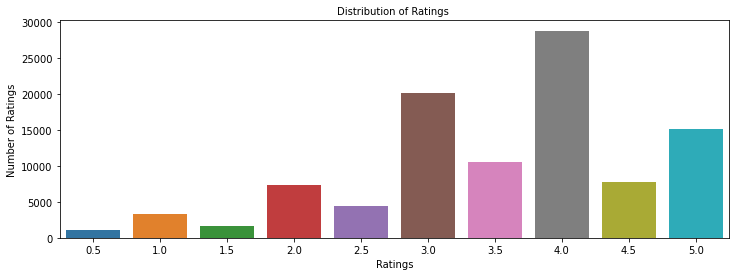

In [13]:
plt.figure(figsize = (12, 4))

sns.countplot(data=rating, x='rating')

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

**As per the diagram above, rating 4.0 has the highest frequesnty (with almost 30000 ratings), followed by rating 3.0 (with almost 20000 ratings). The frequency of ratings has two peaks (not one peak) which are 3 and 4 (it can be a little biased towards 3 and 4).**

### **What is the total number of unique users and unique movies?**


In [14]:
# Finding number of unique users

rating['userId'].nunique()

671

**There are 671 unique users in this database.**

In [15]:
# Finding number of unique movies

rating['movieId'].nunique()

9066

**There are 9066 unique movies in this database. If every user had rated every single movie, we would had 671 * 9066 = 6083286 ratings. However, we only have 100004 ratings. So there are some movies that have not been rated by some users.**

### **Determining if there is a movie which the same user interacted with it more than once**

In [16]:
rating.groupby(['userId', 'movieId']).count()

rating
userId movieId        
1      31            1
       1029          1
       1061          1
       1129          1
       1172          1
...                ...
671    6268          1
       6269          1
       6365          1
       6385          1
       6565          1

[100004 rows x 1 columns]

In [17]:
rating.groupby(['userId', 'movieId']).count()['rating'].sum()

100004

**The sum of ratings for movies is equal to the toal number of ratings in the dataset (100004). So there is no movie for which a user has interacted with more than once.**

### **Determining the most interacted movie in the dataset**

In [22]:
rating['movieId'].value_counts()

356       341
296       324
318       311
593       304
260       291
         ... 
98604       1
103659      1
104419      1
115927      1
6425        1
Name: movieId, Length: 9066, dtype: int64

**Movie 356 has the most number of interactions with 341 number of ratings.**

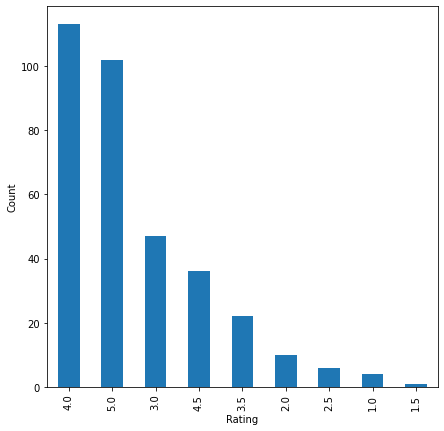

In [23]:
# Plotting distributions of ratings for 341 interactions with movieid 356 
plt.figure(figsize=(7,7))

rating[rating['movieId'] == 356]['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')

plt.show()

**Most users who have rated movie 356 have rated it 4.0 and 5.0. The rating distribution for this movie is skewed towards 4.0 and 5.0 which means that most users have liked this movie.**

### **Determining which user interacted the most with any movie in the dataset**

In [27]:
rating['userId'].value_counts()

547    2391
564    1868
624    1735
15     1700
73     1610
       ... 
296      20
289      20
249      20
221      20
1        20
Name: userId, Length: 671, dtype: int64

 **User 547 had the most number of interactions among all the users in the database with a total number of ratings of 2391.**

### **Determining the distribution of the user-movie interactions in this dataset**

In [34]:
# Finding user-movie interactions distribution
count_interactions = rating.groupby('userId').count()['movieId']
count_interactions

userId
1       20
2       76
3       51
4      204
5      100
      ... 
667     68
668     20
669     37
670     31
671    115
Name: movieId, Length: 671, dtype: int64

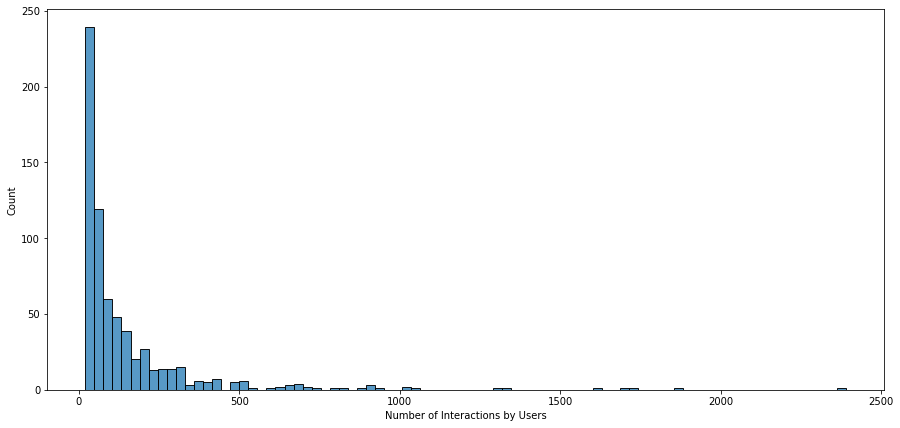

In [32]:
# Plotting user-movie interactions distribution

plt.figure(figsize=(15,7))

sns.histplot(count_interactions)

plt.xlabel('Number of Interactions by Users')

plt.show()

**The plot shows that the user-movie interaction distribution is skewed towards right and only a few users interacted more than 500 times.**

#### As we have now explored the data, let's start building Recommendation systems

## **Creating Rank-Based Recommendation System**

### **Rank-Based Recommendation System**

Rank-based recommendation systems provide recommendations based on the most popular items. This kind of recommendation system is useful when there is **cold start** problems. Cold start refers to the issue when a new user is added into the system and the machine is not able to recommend movies to the new user, as the user did not have any historical interactions in the dataset. In those cases, we can use rank-based recommendation system to recommend movies to the new user.

To build the rank-based recommendation system, the **average** of all the ratings provided to each movie is calculated and then rank them based on their average rating.

In [37]:
# Calculating average ratings
average_rating = rating.groupby('movieId')['rating'].mean()

# Calculating the count of ratings
count_rating = rating.groupby('movieId')['rating'].count()

# Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In [38]:
final_rating.head()

,avg_rating,rating_count
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56


Now, let's create a function to find the **top n movies** for a recommendation based on the average ratings of movies. Also, a **threshold for a minimum number of interactions** for a movie will be considered for recommendation. 

In [39]:
def top_n_movies(data, n, min_interaction=100):
    
    #Finding movies with minimum number of interactions
    recommendations = data[data['rating_count'] >= min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    
    return recommendations.index[:n]

This **function with different n's and minimum interactions** is used to get movies to recommend.

#### **Recommending top 5 movies with 50 minimum interactions based on popularity**

In [40]:
list(top_n_movies(final_rating, 5, 50))

[858, 318, 969, 913, 1221]

#### **Recommending top 5 movies with 100 minimum interactions based on popularity**

In [41]:
list(top_n_movies(final_rating, 5, 100))

[858, 318, 1221, 50, 527]

#### **Recommending top 5 movies with 200 minimum interactions based on popularity**

In [42]:

list(top_n_movies(final_rating, 5, 200))

[858, 318, 50, 527, 608]

Now let's apply the **Collaborative Filtering Based Recommendation Systems**.

## **Model 2: User based Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- I will build **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- I will be using `surprise` library, to build the remaining models. Let's first import the necessary classes and functions from this library.

#### **Making the dataset into surprise dataset and splitting it into train and test set**

In [43]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

#### **Build the first baseline similarity based recommendation system using cosine similarity and KNN**

In [45]:

# Defining Nearest neighbour algorithm
algo_knn_user = KNNBasic(sim_options = {'name': 'cosine',
               'user_based': True}, verbose=False, random_state=1)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_user.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_user.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9925


0.9924509041520163

**The RMSE for this user-user model is 0.99.**

### **Determining the Predicted  rating for a user with userId=4 and for movieId=10 and movieId=3**

Let's us now predict rating for an user with `userId=4` and for `movieId=10`

In [46]:
algo_knn_user.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.62   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.6244912065910952, details={'actual_k': 40, 'was_impossible': False})

**The predicted movie rating for userid 4 and movieid 10 is 3.6, while the actual rating is 4.**

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`

In [47]:
algo_knn_user.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.20   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.202703552548654, details={'actual_k': 40, 'was_impossible': False})

**The predicted movie rating for userid 4 and movieid 10 is 3.2**

### **Improving user-user similarity based recommendation system by tuning its hyper-parameters**

Below I will be tuning hyper-parmeters for the `KNNBasic` algorithms. Let's try to understand different hyperparameters of KNNBasic algorithm - 

- **k** (int) – The (max) number of neighbors to take into account for aggregation (see this note). Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - pearson
    - pearson baseline

### **Performing hyperparameter tuning for the baseline user based collaborative filtering recommendation system and finding the RMSE for tuned user based collaborative filtering recommendation system**

In [104]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9], 'sim_options': {'name': ['cosine','msd','pearson','pearson_baseline'], 'user_based': [True]} } 

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9659356041922438
{'k': 20, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': True}}


Once the grid search is **complete**, the **optimal values for each of those hyperparameters** can be obtained as shown above.

Below I am analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [106]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,1.011135,1.003843,1.010502,1.008493,0.003299,31,0.781686,0.775090,0.780862,0.779213,0.002935,25,0.678882,0.130141,2.658661,0.135227,"{'k': 10, 'min_k': 3, 'sim_options': {'name': ...",10,3,"{'name': 'cosine', 'user_based': True}"
1,0.970945,0.965901,0.970535,0.969127,0.002287,3,0.745777,0.741728,0.744571,0.744026,0.001698,2,0.121928,0.012016,2.449384,0.062408,"{'k': 10, 'min_k': 3, 'sim_options': {'name': ...",10,3,"{'name': 'msd', 'user_based': True}"
2,1.012366,1.007245,1.012038,1.010550,0.002341,33,0.787557,0.781966,0.787306,0.785610,0.002578,34,0.878014,0.144175,2.624576,0.071131,"{'k': 10, 'min_k': 3, 'sim_options': {'name': ...",10,3,"{'name': 'pearson', 'user_based': True}"
3,1.003480,0.999076,1.004357,1.002305,0.002311,26,0.781293,0.775613,0.780469,0.779125,0.002506,24,0.695586,0.082173,2.455647,0.059855,"{'k': 10, 'min_k': 3, 'sim_options': {'name': ...",10,3,"{'name': 'pearson_baseline', 'user_based': True}"
4,1.012927,1.006914,1.013958,1.011266,0.003106,34,0.782987,0.777421,0.783380,0.781263,0.002721,30,0.887710,0.296619,2.934005,0.526673,"{'k': 10, 'min_k': 6, 'sim_options': {'name': ...",10,6,"{'name': 'cosine', 'user_based': True}"


Now, let's build the **final model by using tuned values of the hyperparameters**, which was obtained by using **grid search cross-validation**.



In [56]:
# Using the optimal similarity measure for user-user based collaborative filtering
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_user = KNNBasic(sim_options = {'name': 'msd',
               'user_based': True},k=20, min_k=3, verbose=True)

# Training the algorithm on the trainset
similarity_algo_optimized_user.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_user.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9571


0.9571445417153293

**The RMSE for the tuned model is 0.95 which is smaller than the RMSE for the baseline model (0.99).**

### **Determining the Predicted rating for a user with userId =4 and for movieId= 10 and movieId=3 using tuned user based collaborative filtering**

Let's us now predict rating for an user with `userId=4` and for `movieId=10` with the optimized model:

In [54]:
similarity_algo_optimized_user.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.74   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.740028692988536, details={'actual_k': 20, 'was_impossible': False})

**The predicted rating for userid 4 and movieid 10 is 3.74, when the actual rating is 4. The predicted rating in the baseline model was 3.62.**

Below I am predicting rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`, by using the optimized model:

In [55]:
similarity_algo_optimized_user.predict(4,3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.72   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.7228745701935386, details={'actual_k': 20, 'was_impossible': False})

**The predicted movie rating for userid 4 and movieid 10 is 3.74. The predicted movie rating in the baseline model was 3.20.**

### **Identifying similar users to a given user (nearest neighbors)**

Using KNN algorithm, below I am finding 5 most similar user to the `userId=4` based on the `msd` distance metric

In [57]:
similarity_algo_optimized_user.get_neighbors(4, k=5)

[665, 417, 647, 654, 260]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below I will be implementing a function where the input parameters are - 

- data: a rating dataset
- user_id: an user id against which we want the recommendations
- top_n: the number of movies we want to recommend
- algo: the algorithm we want to use to predict the ratings

In [71]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended movie ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # Extracting those movie ids which the user_id has not interacted yet
    non_interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the movie id which user_id has not interacted yet
    for item_id in non_interacted_movies:
        
        # Predicting the ratings for those non interacted movie ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating movies for this user

#### **Predicted top 5 movies for userId=4 with similarity based recommendation system**

In [72]:
recommendations = get_recommendations(rating,4,5,similarity_algo_optimized_user)

In [73]:
recommendations

[(309, 5),
 (3038, 5),
 (6273, 4.928202652354184),
 (98491, 4.863224466679252),
 (2721, 4.845513973527148)]

## **Model 3: Item based Collaborative Filtering Recommendation System**

In [75]:
# Definfing similarity measure
sim_options = {'name': 'cosine',  'user_based': False} 

# Defining Nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_item.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_item.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.0032


1.003221450633729

**The RMSE for item based system is 1.0032 which is higher than RMSE for item-based model.**



Let's us now predict rating for an user with `userId=4` and for `movieId=10`

### **Determining the Predicted  rating for an user with userId =4 and for movieId= 10 and movieId=3**

In [77]:
algo_knn_item.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.37   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.373794871885004, details={'actual_k': 40, 'was_impossible': False})

**The movie rating for userid 4 and movieid 10 using the item-based model is 4.37.**


Let's predict  the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`

In [78]:
algo_knn_item.predict(4,3, verbose=True)

user: 4          item: 3          r_ui = None   est = 4.07   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=4.071601862880049, details={'actual_k': 40, 'was_impossible': False})

**The movie rating for userid4 and movieid3 is 4.07**


### **Performing hyperparameter tuning for the baseline item based collaborative filtering recommendation system and finding the RMSE for tuned item based collaborative filtering recommendation system**

In [107]:

# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9], 'sim_options': {'name': ['cosine','msd','pearson','pearson_baseline'], 'user_based': [False]} } 


# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9441557971277373
{'k': 30, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above**

Below I am analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [109]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,1.050228,1.050413,1.038670,1.046437,0.005493,34,0.821662,0.821715,0.810558,0.817979,0.005247,34,21.833743,0.301865,13.625738,2.121337,"{'k': 10, 'min_k': 3, 'sim_options': {'name': ...",10,3,"{'name': 'cosine', 'user_based': False}"
1,0.980329,0.977872,0.972547,0.976916,0.003248,16,0.757714,0.757660,0.750425,0.755266,0.003423,16,7.232068,0.282139,10.735266,0.451720,"{'k': 10, 'min_k': 3, 'sim_options': {'name': ...",10,3,"{'name': 'msd', 'user_based': False}"
2,1.032723,1.028841,1.020276,1.027280,0.005200,33,0.805631,0.801011,0.793509,0.800050,0.004995,31,27.829699,0.935534,10.686216,0.595218,"{'k': 10, 'min_k': 3, 'sim_options': {'name': ...",10,3,"{'name': 'pearson', 'user_based': False}"
3,0.974361,0.964697,0.965771,0.968277,0.004325,14,0.737242,0.730579,0.728954,0.732259,0.003586,11,12.301905,1.248622,10.464756,0.505836,"{'k': 10, 'min_k': 3, 'sim_options': {'name': ...",10,3,"{'name': 'pearson_baseline', 'user_based': False}"
4,1.050532,1.050677,1.038819,1.046676,0.005556,35,0.821978,0.821911,0.810765,0.818218,0.005270,35,20.048689,0.836847,10.723061,0.636598,"{'k': 10, 'min_k': 6, 'sim_options': {'name': ...",10,6,"{'name': 'cosine', 'user_based': False}"


Now let's build the **model** by using **tuned values of the hyperparameters** which were obtained by using grid search cross-validation.

In [80]:
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options = {'name': 'msd',
               'user_based': False}, k=30, min_k=3,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_item.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9468


0.9468088882738848

**The RMSE for the optimized model of item-based is 0.945. The RMSE has been decreased from the original one of this model.**

### **Determining the predicted rating for an item with userId =4 and for movieId= 10 and movieId=3 using tuned item based collaborative filtering**

Let's us now predict rating for an user with `userId=4` and for `movieId=10` with the optimized model as shown below

In [81]:
similarity_algo_optimized_item.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.30   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.298279280483517, details={'actual_k': 30, 'was_impossible': False})

 **The predicted movie rating for userid 4 and movieid 10 is 4.29 while the actual rating is 4. The predicted rating is close to the actual one.**

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`, by using the optimized model:

In [82]:
similarity_algo_optimized_item.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.86   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.859023126306401, details={'actual_k': 30, 'was_impossible': False})

**The movie rating for userid 4 and movieid 3 is 3.85.**

### **Identifying similar users to a given user (nearest neighbors)**
Using KNNBasic algorithm, below I find the 5 most similar user to the `userId=4` based on the `msd` distance metric

In [83]:
similarity_algo_optimized_item.get_neighbors(4, k=5)

[77, 85, 115, 119, 127]

#### **Predicted top 5 movies for userId=4 with similarity based recommendation system**

In [84]:
recommendations = get_recommendations(rating, 4, 5, similarity_algo_optimized_item)

In [85]:
recommendations

[(84, 5), (1040, 5), (2481, 5), (3078, 5), (3116, 5)]

## **Model 4: Based Collaborative Filtering - Matrix Factorization using SVD**

### **Singular Value Decomposition (SVD)**

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when there are **miss values** in the **user-item matrix**.

First it is required to convert the below movie-rating dataset:

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF3.PNG)

into an user-item matrix as shown below:

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF6.PNG)

**SVD decomposes this above matrix into three separate matrices:**
- U matrix
- Sigma matrix
- V transpose matrix

#### **U-matrix**

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF7.PNG)

the above matrix is a n x k matrix, where:
- n is number of users
- k is number of latent features

#### **Sigma-matrix**

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF8.PNG)

the above matrix is a k x k matrix, where:
- k is number of latent features
- Each diagonal entry is the singular value of the original interaction matrix

#### **V-transpose matrix**

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF9.PNG)

the above matrix is a kxn matrix, where:
- k is the number of latent features
- n is the number of items

### **Building a baseline matrix factorization recommendation system**

In [86]:
# Using SVD matrix factorization
algo_svd = SVD()

# Training the algorithm on the trainset
algo_svd.fit(trainset)

# Predicting ratings for the testset
predictions = algo_svd.test(testset)

# Computing RMSE on the testset
accuracy.rmse(predictions)

RMSE: 0.9043


0.9043321610026025

**The RMSE for the matrix factorization model is 0.90, which has been reduced from previous models.**

### **Determining the predicted  rating for an user with userId =4 and for movieId= 10 and movieId=3**

Let's us now predict rating for an user with `userId=4` and for `movieId=10`

In [87]:
algo_svd.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.09   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.086426571506476, details={'was_impossible': False})

**The predicted movie rating of userid 4 for movieid 10 is 4.08 while the actual rating is 4.00. The predicted rating is even closer to the actual rating as compared to previous models.**

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`:

In [88]:
algo_svd.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.60   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.6043988058834464, details={'was_impossible': False})

**The predicted movie rating for userid 4 and movieid 3 is 3.60**

### **Improving matrix factorization based recommendation system by tuning its hyper-parameters**

Below I will be tuning only three hyperparameters -
- **n_epochs**: The number of iteration of the SGD algorithm
- **lr_all**: The learning rate for all parameters
- **reg_all**: The regularization term for all parameters

### **Performing hyperparameter tuning for the baseline SVD based collaborative filtering recommendation system and finding the RMSE for tuned SVD based collaborative filtering recommendation system**

In [89]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8945485959315107
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


Below I am analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [90]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all
0,0.948381,0.946293,0.935230,0.943302,0.005771,25,0.741530,0.740745,0.732831,0.738369,0.003929,25,5.202060,0.272817,0.575534,0.093997,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.2}",10,0.001,0.2
1,0.953049,0.951278,0.939342,0.947890,0.006087,26,0.746632,0.746669,0.737771,0.743690,0.004186,26,5.254085,0.223589,0.612748,0.096140,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.4}",10,0.001,0.4
2,0.958495,0.955865,0.944650,0.953003,0.006004,27,0.752598,0.751667,0.743396,0.749220,0.004136,27,5.095928,0.165512,0.604218,0.059176,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.6}",10,0.001,0.6
3,0.914020,0.909038,0.899162,0.907406,0.006175,10,0.707405,0.704341,0.697306,0.703017,0.004228,9,5.335561,0.303156,0.617122,0.067466,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.2}",10,0.005,0.2
4,0.921207,0.916538,0.906277,0.914674,0.006236,15,0.715246,0.712556,0.704881,0.710894,0.004392,15,5.496433,0.294197,0.605269,0.080135,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}",10,0.005,0.4


Now, I will **build final model** by using **tuned values** of the hyperparameters, which were obtained using grid search cross-validation above.

In [92]:

# Building the optimized SVD model using optimal hyperparameter search
svd_algo_optimized = SVD(n_epochs=30, lr_all=0.01, reg_all=0.2)

# Training the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# Predicting ratings for the testset
predictions = svd_algo_optimized.test(testset)

# Computing RMSE
accuracy.rmse(predictions)

RMSE: 0.8955


0.8954850385073118

### **Determining the predicted rating for an user with userId =4 and for movieId= 10 and movieId=3 using SVD based collaborative filtering**

Let's us now predict rating for an user with `userId=4` and for `movieId=10` with the optimized model

In [93]:
svd_algo_optimized.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.98   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.9808308136490056, details={'was_impossible': False})

**The predicted movie rating for userid 4 and movieid10 is 3.98 which is very similar to the actual rating of 4.**

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`:

In [ ]:
svd_algo_optimized.predict(4, 3, verbose=True)

### **Predicting the top 5 movies for userId=4 with SVD based recommendation system**

In [95]:
get_recommendations(rating, 4, 5, svd_algo_optimized)

[(3310, 4.989049456609989),
 (1192, 4.987188432916515),
 (116, 4.957913445327629),
 (926, 4.945430945436577),
 (1948, 4.913924388943234)]

### **Predicting ratings for already interacted movies** 

Below I am comparing the rating predictions of users for those movies which has been already watched by an user. This will help us to understand how well are predictions are as compared to the actual ratings provided by users

In [96]:
def predict_already_interacted_ratings(data, user_id, algo):
    
    # Creating an empty list to store the recommended movie ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # Extracting those movie ids which the user_id has interacted already
    interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].notnull()].index.tolist()
    
    # Looping through each of the movie id which user_id has interacted already
    for item_id in interacted_movies:
        
        # Extracting actual ratings
        actual_rating = user_item_interactions_matrix.loc[user_id, item_id]
        
        # Predicting the ratings for those non interacted movie ids by this user
        predicted_rating = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, actual_rating, predicted_rating))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return pd.DataFrame(recommendations, columns=['movieId', 'actual_rating', 'predicted_rating']) # returing top n highest predicted rating movies for this user

Here I am comparing the predicted ratings by `similarity based recommendation` system against actual ratings for `userId=7`

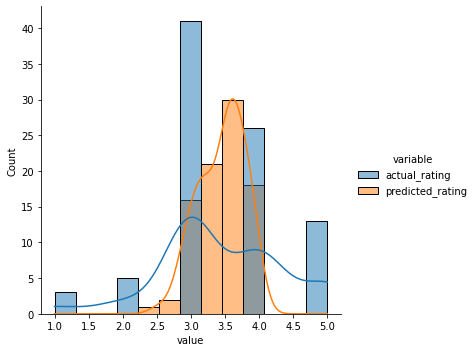

In [97]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, similarity_algo_optimized_item)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

**It can be observed from the above plot that the distribution of the predicted ratings closely follow that of actual ratings. Both of them have higher peaks around 3 and 4 (we also saw higher distribution around 3 and 4 for actual ratings during the EDA). It can also be seen that float ratings (i.e. 1.5, 2.5, 3.5, etc) show predicted ratings but do not show actual ratings because the predicted ratings are float numbers while the actual ratings are integers (i.e. 1, 2, 3, etc)**

Below I am comparing the predicted ratings by `matrix factorization based recommendation` system against actual ratings for `userId=7`

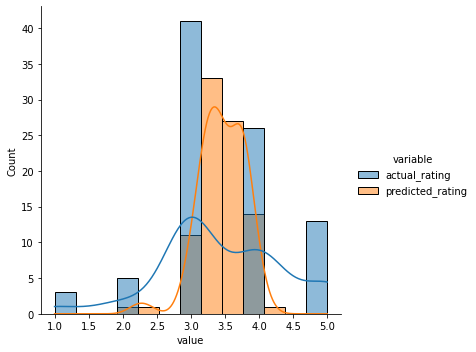

In [98]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, svd_algo_optimized)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

In [99]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

### **Computing the precision and recall, for each of the 6 models, at k = 5 and 10. This is 6 x 2 = 12 numerical values.**

In [100]:
# Function can be found on surprise documentation FAQs
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls



In [102]:
# A basic cross-validation iterator.
kf = KFold(n_splits=5)

# Make list of k values
K = [5, 10]

# Make list of models
models = [algo_knn_user, similarity_algo_optimized_user,algo_knn_item,similarity_algo_optimized_item,algo_svd,svd_algo_optimized ]

for k in K:
    for model in models:
        print('> k={}, model={}'.format(k,model.__class__.__name__))
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

            # Precision and recall can then be averaged over all users
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        
        print('-----> Precision: ', round(sum(p) / len(p), 3))
        print('-----> Recall: ', round(sum(r) / len(r), 3))

> k=5, model=KNNBasic
-----> Precision:  0.767
-----> Recall:  0.41
> k=5, model=KNNBasic
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
-----> Precision:  0.777
-----> Recall:  0.421
> k=5, model=KNNBasic
-----> Precision:  0.61
-----> Recall:  0.327
> k=5, model=KNNBasic
-----> Precision:  0.682
-----> Recall:  0.36
> k=5, model=SVD
-----> Precision:  0.757
-----> Recall:  0.384
> k=5, model=SVD
-----> Precision:  0.746
-----> Recall:  0.383
> k=10, model=KNNBasic
-----> Precision:  0.75
-----> Recall:  0.548
> k=10, model=KNNBasic
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matr

### **Conclusion**


In this case study, three different ways of building recommendation systems were utilized: 
- rank-based using averages
- similarity-based collaborative filtering
- model-based (matrix factorization) collaborative filtering

**1- The baseline results for user-user and item-item based are 0.99 and 1.0, respectively. These two error terms are very similar to each other, implying that there is not much difference between the baseline models.**


**2- The RMSE value for the optimized versions of user-user and item-item models are 0.95 and 0.94, respectively (for the testset). Both of these RMSE values have decreased from the baseline models which means that hyperparameter tuning has worked, but they are still close to each other (although the item-item based model shows a very small advantage).**


**3- Collaborative filtering method examines the similarities between users or items and predicts final outcome based on these similarities. However, matrix factorization works by decomposing the data into smaller matrices that explain latent features of users and items, and provides prediction by using the latent features. In this case, the original and optimized RMSE for SVD method are 0.90 and .89. Both of these values are lower than those of collaborative filtering, meaning that the SVD method can provide better predictions with lower errors. However, the optimized version of SVD did not help much with lowering the RMSE. In terms of prevcision and recall, the precision and recall of user-user based model for K=5 are 0.77 and 0.42, respectively, which are higher than those of item-item based and SVD. This is true for K=10 as well. Thus, the user-user based model has better precision and recall as compared to the other two models.**


**4- It is observed that the SVD model provides lower RMSE as compared to other two models, but the user-user based model provides better precision and recall. The business objective defines which one is more important and has to be considered. The reason that SVD provides lower RMSE is because it studies the latent features of users and items (obtained by analyzing the matrix), and extracts features from users and items. Therefore, it provides better predictions based latent features.**
